pip install torch torchvision torchaudio

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = 'lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(device)
else:
    print ("MPS device not found.")


mps


torch.Size([250, 250, 3])


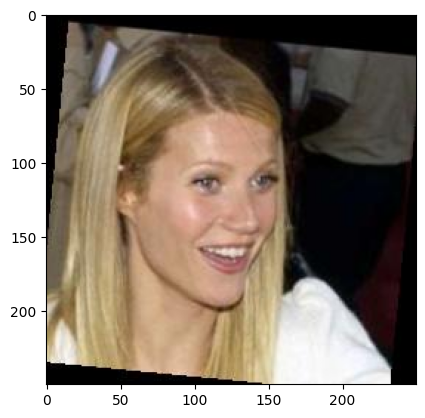

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

**Channels:** The first dimension in the image shape (image_shape[0]) represents the number of color channels. In standard RGB images, this is usually 3 (corresponding to Red, Green, and Blue channels).

**Height:** The second dimension (image_shape[1]) is the height of the image in pixels. It shows how many pixels there are from the top to the bottom of the image.

**Width:** The third dimension (image_shape[2]) is the width of the image in pixels. It shows number of pixels from the left to the right side of the image.

In summary, shape [C, H, W] means there are C color channels, each with a dimension of H pixels in height and W pixels in width. When displaying the image with matplotlib, the image needs to be permuted to [H, W, C] since matplotlib expects the color channels to be the last dimension.

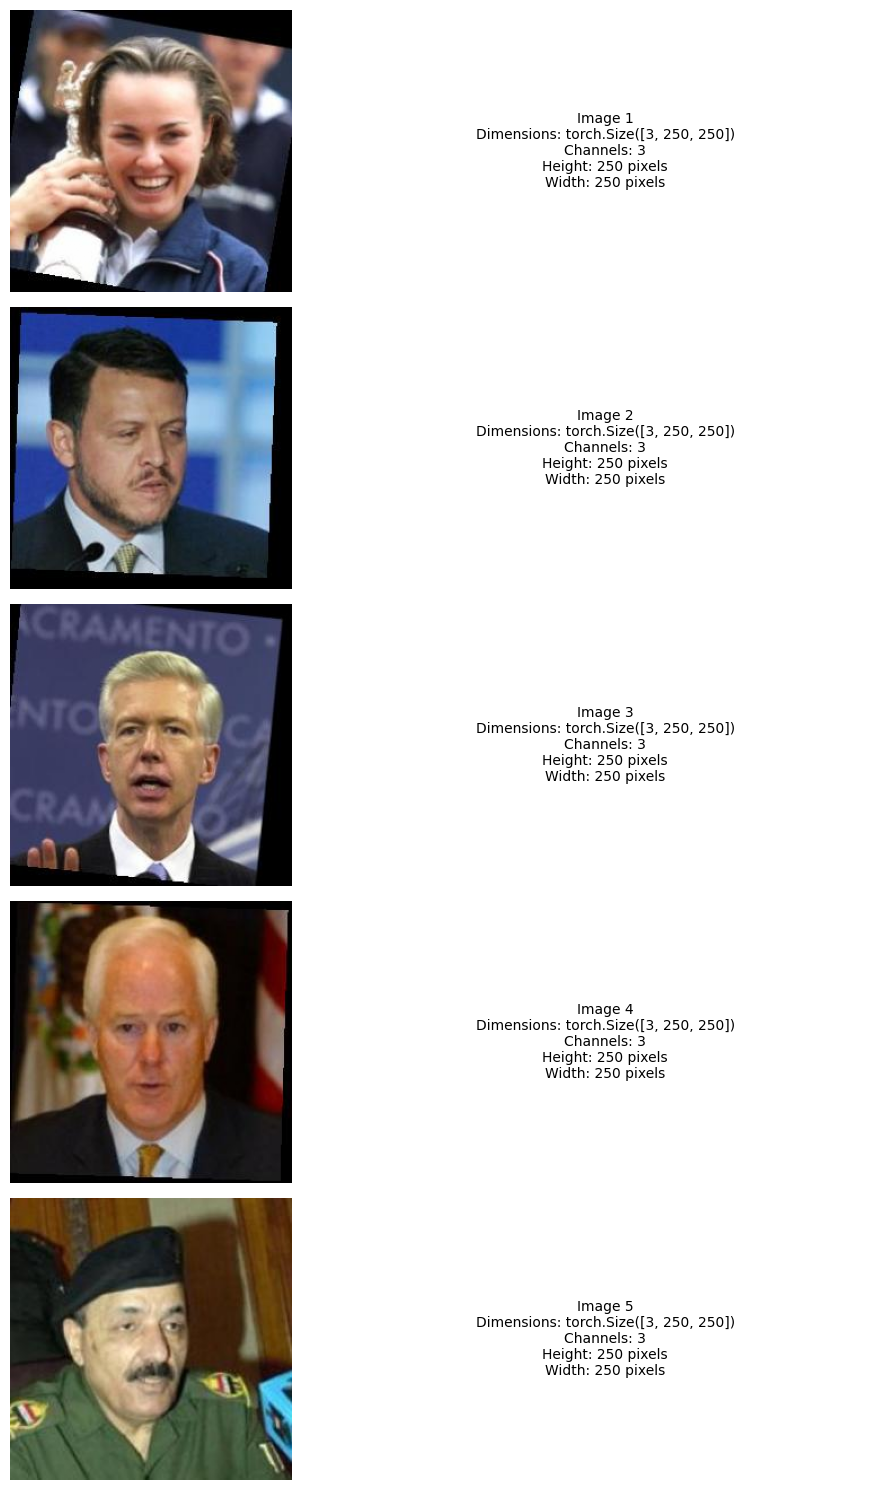

In [6]:
num_images_to_show = 5
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 15))  # Adjusting the size as needed

for i, (x, y) in enumerate(dataloader):
    if i >= num_images_to_show:
        break

    image = x[0]  # with first image in the batch
    image_shape = image.shape  # Shape of the image

    # Permutation of the image for display ([C, H, W] to [H, W, C])
    image_display = image.permute(1, 2, 0)

    # Displaying the image
    axes[i, 0].imshow(image_display)
    axes[i, 0].axis('off')  # Hide the axis

    # Displaying the text
    text_str = f"Image {i+1}\nDimensions: {image_shape}\nChannels: {image_shape[0]}\nHeight: {image_shape[1]} pixels\nWidth: {image_shape[2]} pixels"
    axes[i, 1].text(0.5, 0.5, text_str, ha='center', va='center')
    axes[i, 1].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder layers
        self.encoder_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=0),  
            nn.Sigmoid()
        )

    def encoder(self, x):
        return self.encoder_layers(x)

    def decoder(self, x):
        return self.decoder_layers(x)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [8]:
model = AE()

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# Moving model to the MPS device and set it to evaluation mode
model = model.to(device)
model.eval()

# fetching a sample image from the dataloader
for images, _ in dataloader:
    sample_image = images[0].unsqueeze(0)  # Add a batch dimension
    break

# Moving input data to MPS device
sample_image = sample_image.to(device)

# Passing image through the model
with torch.no_grad():
    encoded_output = model.encoder(sample_image)
    print("Encoded Output Shape:", encoded_output.shape)

    reconstructed_image = model.decoder(encoded_output)
    print("Decoded Output Shape:", reconstructed_image.shape)

Using device: mps
Encoded Output Shape: torch.Size([1, 128, 31, 31])
Decoded Output Shape: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

### Loss Function

For an autoencoder, especially one dealing with image data, a common choice for a loss function is the Mean Squared Error (MSE) loss.:

- **MSE Loss**: This calculates the average squared difference between estimated values and actual value. In the context of an autoencoder, it measures how close the reconstructed images are to original images on a pixel-by-pixel basis. This makes it suitable for tasks as the input image is crucial.

The choice of loss function can vary based on task to be completed. For instance, if the autoencoder is used for denoising, we might still use MSE between the clean image and the reconstructed image. For more complex tasks, like those involving variational autoencoders, different loss functions that include terms for latent space distribution might be used.

### Creating an Optimizer for Training

The optimizer is a important component in training neural networks. It updates network’s weights based on the loss gradient. The choice of optimizer and its settings can significantly impact the training process and the final performance of the model.

- **Common Optimizers**: Adam (Adaptive Moment Estimation) is widely used due to its effectiveness in handling sparse gradients and adapting the learning rate. However, other optimizers like Stochastic Gradient Descent (SGD), RMSprop and many others are also popular, depending on the specific task or application.

- **Learning Rate**: One of the most important hyperparameters for training. If it is too high, the model might overshoot minima; if it is too low, model might take too long to converge in local minima.

- **Other Hyperparameters**: These include momentum, decay rates and are optimizer-specific.

In summary, setting up a model for training involves understanding its parameters, choosing the right loss function to guide learning, and selecting an appropriate optimizer to efficiently update the model weights. These choices are interdependent and can significantly impact the model learning capability and performance.

In [10]:
parameters_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {parameters_count}")

Total number of trainable parameters: 331715


In [11]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Troubleshooting in this scenario involves systematic adjustments and checks, ranging from hyperparameter tuning to evaluating the data preprocessing steps. Addressing potential issues, we can identify and resolve the factors causing the model learning process.

**Adjust Learning Rate:** If it's too high, the model may not converge; if too low, training could be slow.

**Check Model Architecture:** Ensure the model is neither too simple nor too complex for your data.

**Data Quality and Preprocessing:** Verify data integrity and consider normalization or standardization.

**Batch Size:** Experiment with different sizes; too large or too small batches can affect training.

**Regularization:** Add dropout or weight regularization to prevent overfitting.

**Optimizer:** Try different optimizers (e.g., SGD, RMSprop) if Adam isn't working well.

**Learning Rate Scheduler:** Implement a scheduler to reduce the learning rate over epochs.

**Early Stopping:** Stop training when the validation loss starts to increase.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# instance of autoencoder class
model = AE()  

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Moving model to the chosen device
model.to(device)

# Defining optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

epoch_value = 20

# Training loop
for epoch in range(epoch_value):
    total_loss = 0.0
    for batch in dataloader:
        inputs, _ = batch  # Assuming dataloader returns (input, label)
        inputs = inputs.to(device)  # Move inputs to the same device as the model
        optimizer.zero_grad()

        # Forward, backward optimization with loss function caluculation
        encoded = model(inputs)
        loss = loss_function(encoded, inputs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    # Print average loss for this epoch
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")

Using device: mps
Epoch 1, Loss: 0.005417498786639026
Epoch 2, Loss: 0.001702011390088648
Epoch 3, Loss: 0.0013230130386286852
Epoch 4, Loss: 0.0011681728070637813
Epoch 5, Loss: 0.0010399559088409
Epoch 6, Loss: 0.0009069102616634238
Epoch 7, Loss: 0.0008026466070525888
Epoch 8, Loss: 0.0007723284326971774
Epoch 9, Loss: 0.0006564204423752465
Epoch 10, Loss: 0.0006266308479221394
Epoch 11, Loss: 0.000584803145111129
Epoch 12, Loss: 0.0005434782577201652
Epoch 13, Loss: 0.0005495600772269097
Epoch 14, Loss: 0.0004986296758670945
Epoch 15, Loss: 0.00047393941353097703
Epoch 16, Loss: 0.000504526857088167
Epoch 17, Loss: 0.0004443942059105901
Epoch 18, Loss: 0.000419497360157047
Epoch 19, Loss: 0.0004131050911453071
Epoch 20, Loss: 0.0004131534118694591


##  Step 7
Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

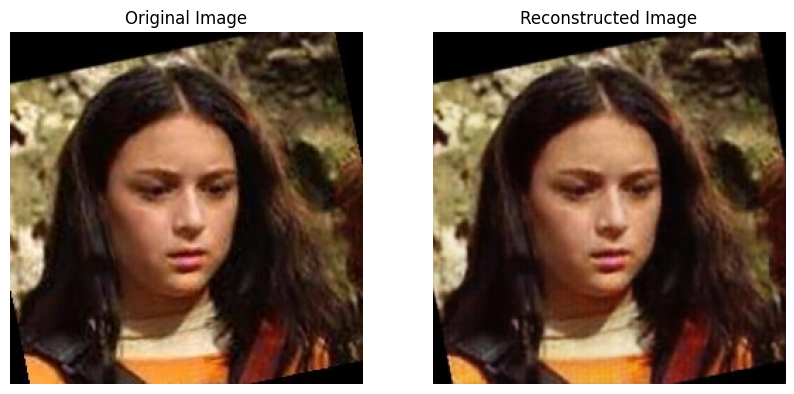

In [31]:
import random
import matplotlib.pyplot as plt

# changing model to evaluation mode
model.eval()

# Choosing a random index from given dataset lfw
random_index = random.randint(0, len(dataloader) - 1)

# Retrieving the random image
sample_image, _ = dataloader.dataset[random_index]

# Moving the image to same device as the model
sample_image = sample_image.to(device)

# Passing the image via the model to get the encoded and decoded outputs
with torch.no_grad():
    encoded_output = model.encoder(sample_image.unsqueeze(0))
    decoded_output = model.decoder(encoded_output)

# Converting tensors to numpy arrays for plotting
sample_image_np = sample_image.cpu().numpy().transpose(1, 2, 0)
decoded_image_np = decoded_output[0].cpu().numpy().transpose(1, 2, 0)

# Plotting the original and reconstructed images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_image_np)
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[1].imshow(decoded_image_np)
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

Adding noise to the latent representation in an autoencoder can affect the decoded image in several ways:

### Image Quality Degradation
Noise in the encoded representation leads to a decrease in image quality, causing blurriness and artifacts in the decoded image.

### Loss of Detail
Important details and fine features in the image might get lost or distorted due to the noise.

### Color and Brightness Shifts
Noise can alter the color balance and brightness levels in the reconstructed image.

### Impact on Autoencoder Training
In training, noise can help in building robustness, but during inference, it typically degrades output quality.

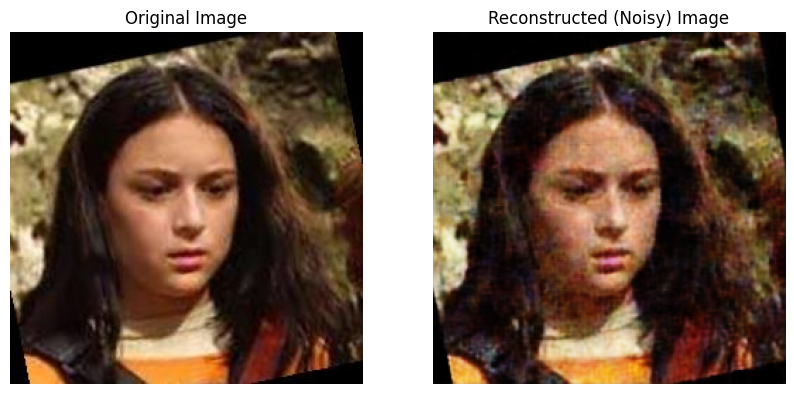

In [32]:
import random
import torch
import matplotlib.pyplot as plt

# keeping model to evaluation mode
# model.eval()

# Choosing a random index from dataset
# random_index = random.randint(0, len(dataloader.dataset) - 1)

# # Retrieving the random image
# sample_image, _ = dataloader.dataset[random_index]

# # Moving image to the same device as the model
# sample_image = sample_image.to(device)

# Passing image through the model to get the encoded output
with torch.no_grad():
    encoded_output = model.encoder(sample_image.unsqueeze(0))

# Increasing the standard deviation for more noise
noise_stddev = 0.5  # Increased noise level
noise = torch.randn_like(encoded_output) * noise_stddev
noisy_encoded_output = encoded_output + noise

# Decode the noisy encoded representation
with torch.no_grad():
    decoded_output = model.decoder(noisy_encoded_output)

# Convert the tensors to numpy arrays for plotting
sample_image_np = sample_image.cpu().numpy().transpose(1, 2, 0)
decoded_image_np = decoded_output[0].cpu().numpy().transpose(1, 2, 0)

# Plot the original and reconstructed (noisy) images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_image_np)
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[1].imshow(decoded_image_np)
axes[1].set_title("Reconstructed (Noisy) Image")
axes[1].axis('off')

plt.show()
